# Tutorial on Toy Generation  to be used for limit production

# In a nutshell:  Neymann construction with likelihood ratio

## Some definitions:
- **mu** is our parameter of interest, the signal strenght, it can be considered as equal to the number of signal events. Altough there is a small difference (out of the scope of this tutorial).
- **q_mu** is the test statistic, the likelihood ratio. This is a function of the "tested" value of **mu**.
- **H_mu** is the signal hypothesis with a signal strenght **mu**.
- **H_0** is the null hypothesis, background only.

## General Idea
Porduce limits with the Neymann construction method. Typically this means that one wants to reject the signal hypothesis **H_mu**  in favour of the null, **H_0**. The whole game is then to find the value of **mu** for which the **H_mu** is rejected at 90% CL. To do so one needs the distibution of the test statistic **q_{mu}** under signal hypothesis **H_mu** (assuming that **H_mu** is true).
The whole procedure is quite involved, but can be divided in a few points:

**Produce the 90% quantiles curve** 
- Produce several MC toy datasets related to a specific hypothesis **mu**.
- **Fit** those datastes, meaning, compute the **q_mu**, testing the same exact **mu** for under which the toys are generated
- Now you have many **q_mu** values for a given **mu** test and the related hypothesis. So you have the distro of **q_mu** under the hypothesis **H_mu**. So you can compute the 90% quantile of that distribution **q_mu_90**, or in other words the value of **q_mu** that correspond to a p-value of 10%.
- Now you can repeat the procedure for a prefixed set of values of **mu** and obtain a set of **q_mu_90** points.
- Interpolate the latter set of points and you'll have a curve describing the evolution of the 90% quantile of the test statistic **q_mu_90** as a function of the tested value of **mu**.
- Now you can use that curve to compute the limits.

**Compute the limits or the sensitivity**
- Given a dataset, that can be real data (for real limit) or toy bkg only data (for sensitivity), one compute the value of **q_mu** for a given **mu**.
- Check that value againts the **q_mu_90** curve to find if its p-value is larger than 10%, if yes that **mu** hypothesis is excluded.
- Find the value of **mu** for which the likelihood ratio curve **q_mu** intersect the **q_mu_90** curve, that is the limit at 90% CL.
- If you are computing the real limmit then you are done, if you are computing sensitivity then repeat these last 2 points for many toy datasets untill you'll get the distribution of limits under the **H_0**. Find the median and 1-2sigma of that distro.

# The focus of the tutorial
This tutorial is devoted to show you how to use Xephyr classes to produce MC pseudo-datasets from background and signal models, so to generate toys under any of the **H_mu** hypothesis. We will show that it is very easy to do so once you have previously defined a likelihood.


## The Setup 
First of all I suggest you to produce a single compilable macro that contains the likelihood you want to use, you can find in other tutorial how to define the likelihood [here](https://xenon1t.github.io/Xephyr/docs/tutorials.html). The idea of this macro is to define a function that you can use to retrieve the likelihood, so that you have it defined in one place only.You can get inspiration on how to write this function from [here](https://github.com/XENON1T/Xephyr/blob/master/examples/SR1Like/src/likelihoodDef.cxx).

This tutorial depends on the likelihood definition of SR1,  so you need to download the SR1 repository.
```bash
cd XEPHYR_DIR
git clone git@github.com:XENON1T/SR1Results.git SR1

source Xephyr/pacman/installExample.sh  SR1Like      # Install Xephyr example in local dir
```

# Part 1) Retrieve the likelihood

In [1]:
.x ../loadXephyr.C



      =================== Welcome to Xephyr =====================
       Version 6.0 dated 10-Oct-2017, compiled with ROOT 6.14/00

(int) 0


In [2]:
 TString xeDir(gSystem->Getenv("XEPHYR_DIR"));   // Xephyr work Directory 

In [3]:
// add path to include files to ROOT (in the file I'm going to load there are some Xephyr includes) 
gInterpreter->AddIncludePath(xeDir + "Xephyr/src");  // in this case is just XEPHYR src from next dir.

Now we load the SR1 likelihood macro, where the definition of the likelihood is.

In [4]:
gROOT->ProcessLine(".L  " + xeDir +"xephyr_examples/SR1Like/src/likelihoodDef.cxx");

In [5]:
double mass = 50.; // GeV
int likelihood_type = 0;  // [0=inner egg, 1= U volume, 2 = Wall volume]

// The whole SR1 likelihood definition now is in this object here
// There is a notebook about how to build the likelihood, check it out.
pdfLikelihood *likeHood = getTheLikelihood_SR1( mass, likelihood_type ); 

// Initialize the likelihood, you always need to call this after you load all PDFs and nuisance parameters
likeHood->initialize();

// Set parameter of interest constrained positive (not default), because now we want to produce toys
likeHood->getPOI()->setMinimum(0.);


pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/ERBackgroundModel_Stitched_SR1_RunSourceCombinedFit180420.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/Background_wall_ac_templates_v6_inegg_bin_SR1_2018-04-30.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/Background_wall_ac_templates_v6_inegg_bin_SR1_2018-04-30.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/RadiogenicNRBackgroundModel_SR1_RunSourceCombined180420.root
pdfComponent::Constructor - INFO : Reading file /home/pan/work/XEPHYR/SR1/StatisticalAnalyses/inputs_for_likelihood/lax_1.5.1_egg/sliced_2d_templates/Ra

#### Explaination of printout above:
ok, there is a lot of print out:
- The first block tells you what file have been loaded as PDF
- The second block list the loaded bkg component with their names (SR1 has stupid names) and it says if the bkg will have a safeguard uncertainty or not.
- The third block tells you which nuissance parameters are added to the likelihood and to which component they belong

## Part 2) the  ToyGenerator Class

This class is used to generate toys from a [profileLikelihood](https://xenon1t.github.io/Xephyr/class_reference/classProfileLikelihood.html) object, which must be initialized with the models beforehand.

[ToyGenerator](https://xenon1t.github.io/Xephyr/class_reference/classToyGenerator.html) generates an output file with a configurable number of MC toy Tree inside. These tree are generated by random extracting S1, S2, from the provided models (TH2F). The total number of events generated per model is Poisson extracted from the average expectation for that background, also defined in the likelihood. 

The typical flow is:
- You generate a file containing many toy MC datasets, let's say 100 datasets per file. This we call a **GENERATION** of that specific background + signal hypothesis.
- You repeat the generation process again and again, let's say 100 times, so that you have 100 files each containing 100 datasets that are all generated with same input conditions (signal strenght, bkg expectation, nuissance parameters).
- Between each GENERATION you change the seed.
- Each GENERATION should have a slightly different name
- We produce that many GENERATIONS for the same inputs because then is easier to parallelize the Test statistic computation into many different jobs (the FIT stage). This is the topic of the next [tutorial](https://github.com/XENON1T/Xephyr/blob/master/notebooks/ToyFitter.ipynb). 

In [6]:
TString treeName = "test_mu5_V0_Gen1";  // name of the output file and prefix of output toy trees
// This can be any, but we reccomend to use this Pattern:  
// name + injected signal strenght + Volume type + Generation
// in the next we are going to generate toy data with average 5 injected signal events.

TString outDir = xeDir ;            // path to output toy files directory, here set to $XEPHYR_DIR work dir
ToyGenerator toy(treeName,outDir);  // create an instance

In [7]:
toy.setLikelihood(likeHood);        // set the likelihood

In [8]:
toy.setSeed(17);     // you should change the seed as a function of wimp mass and injected signal strenght

In [9]:
// this function would randomize the nuissance parameter according to their definition
// For an approximated (as we always do) Neymann construction is not really needed
// but is there in case you want to use it for pull studies
// /!\ here we are using it for illustration purpose only, you can and should avoid it at the generation stage
toy.randomizeNuissanceParameter();

ToyGenerator::randomizeNuissanceParameter - INFO : Randomizing parameters:
ToyGenerator:: - INFO : Skipping paramater: Sigma
 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 CNNSscale0           Nuisance        -1.4                 
  2 RadioscaleNX0        Nuisance       -0.94                 
  3 Radioscale0          Nuisance        0.36                 
  4 ACscale0             Nuisance        0.78                 
  5 Wallscale0           Nuisance         1.3                 
  6 ERscale0             Free             0.2                 
  7 _py0_                Free            0.12                 
  8 _rf0_                Free             1.7                 
  9 SignalScale0         Nuisance         1.9                 


## Part 3) Generate your first toy data

This is super easy, the toyGenerator class does everything from you based on the info stored in the likelihood.
The only thing you need to do is to fire the function:

```c++
ToyGenerator::generateData(double mu, int N, bool randomizeNP = false)

// mu = signal multiplier,  N = number of datasets
// randomizeNP = flag to randomize or not the nuissance parameter. 
// you want to puth this to false (default is False).
```

**NOTE:** generateData will overwrite any file that has same name as "treeName" above. 

In [10]:
// first let's have a look at what are we generating, let's print the expectation for background and signal
// note that signal number of events are for e-45 cm^2 cross section in this case, for you will be whatever 
//is in the histogram 
likeHood->printEventSummary();  



--------------Event Summary------------------
PdfComponent Name 	Events
CNNS 	 0.0146
NeutronX 	 0.0071
Neutrons 	 0.2358
AC 	 0.3629
Wall 	 0.5447
ER 	 314.8052
Signal 	 78.4239


In [11]:
double mu = 5;             // number of signal injected events
int    N  = 10;           // number of toy datasets generated in the file ( I found that 100 is a nice number )
int    Gen = 1;           

toy.setGeneration( Gen );  // Optional, give a number to this GENERATION, this will be written in output tree
toy.setLikeType( likelihood_type );  // Optional, write to the output tree the likelihood type (integer) info.

toy.setPrintLevel( WARNING );       // to reduce a bit the printout

toy.generateData( mu, N, false );   // generate fake dark matter data, this will create a file in $XEPHYR_DIR 

 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        5                 
  1 CNNSscale0           Nuisance        -1.4                 
  2 RadioscaleNX0        Nuisance       -0.94                 
  3 Radioscale0          Nuisance        0.36                 
  4 ACscale0             Nuisance        0.78                 
  5 Wallscale0           Nuisance         1.3                 
  6 ERscale0             Free             0.2                 
  7 _py0_                Free            0.12                 
  8 _rf0_                Free             1.7                 
  9 SignalScale0         Nuisance         1.9                 


#### Generate Calibration:
The calibration dataset is a special one because one generates it from fewer models, in this case ER + AC + wall.
Also the AC and Wall model utilized here must be different than the one used for the nominal background model (for DM data generation).

The **toyGenerator** class takes the info for the calibration dataset generation from:
- All the models in the likelihood that are flagged **safeguarded**, the relative scale between them is preserved.
- All other additional models that are specific for calibation (and appear only in calibration) but be set using the 
**setAdditionalSafeGuardComponent** of the likelihood.
- Note: in case the safeguard parameter is != 0, then a safeguard component will be also injected in the calibration toys.

In [12]:
int N_cal = 15000;                     // Average number of calibration events from which we Poisson extract.

toy.setAverageCalibrationEvents(N_cal);

// as above but now generate calibration data: generateCalibration(int N, bool randomizeNP = true);
toy.generateCalibration( N, false);  // this will create a file in $XEPHYR_DIR 
// Note that N is the same as above, in fact each DM dataset must have a corresponding calibration dataset.  

## Part 4)  Let's have a look at what we've created
In the specified directory you'll get a file named with your specified "TreeName" with N trees inside.
Each tree contains a TList of the parameter values that have been used for producing that tree and can be considered as the truth for that toy dataset. This info can be accessed with the TTree::GetUserInfo() method.

The Trees contain 3 branches: cs1, cs2 and type. Type is a string that define the type of the specific event, and reports the name of the **pdfComponent** (background or signal model) from which has been extracted.

In [13]:
// Opening and printing output file content:

TFile *file = TFile::Open(outDir + treeName + ".root");  // science data
TFile *cal_file = TFile::Open(outDir + treeName + "_Cal.root");  // The calibration data by convention have the same name but suffix _Cal
file->ls();

TFile**		/home/pan/work/XEPHYR/test_mu5_V0_Gen1.root	
 TFile*		/home/pan/work/XEPHYR/test_mu5_V0_Gen1.root	
  KEY: TTree	test_mu5_V0_Gen1_0;1	generated toy data
  KEY: TTree	test_mu5_V0_Gen1_1;1	generated toy data
  KEY: TTree	test_mu5_V0_Gen1_2;1	generated toy data
  KEY: TTree	test_mu5_V0_Gen1_3;1	generated toy data
  KEY: TTree	test_mu5_V0_Gen1_4;1	generated toy data
  KEY: TTree	test_mu5_V0_Gen1_5;1	generated toy data
  KEY: TTree	test_mu5_V0_Gen1_6;1	generated toy data
  KEY: TTree	test_mu5_V0_Gen1_7;1	generated toy data
  KEY: TTree	test_mu5_V0_Gen1_8;1	generated toy data
  KEY: TTree	test_mu5_V0_Gen1_9;1	generated toy data


In [14]:
// Retrieve one of the toy trees

TTree *tree = (TTree*)file->Get(treeName+"_4");         // science data
TTree *tree_cal = (TTree*)file->Get(treeName+"_Cal4");  // calibration

In [15]:
// Print the value of the nuissance parameter (including parameter of interest) 
// with wich the toy has been generated and are stored as TParameter and in the tree,
// they can be accessed with usual TList functions. 

TList *l = tree->GetUserInfo();  // this is a list stored in TTree
l->Print();                      // let's print the params for one tree, they are stored in TParameter class type.

// Note: sigma here is actually the averaged number of signal injected events  mu (pardon the inconsistency of naming conventions)

Collection name='UserInfo', class='TList', size=10
  TParameter<double>	Sigma = 5
  TParameter<double>	CNNSscale0 = -1.36356
  TParameter<double>	RadioscaleNX0 = -0.939959
  TParameter<double>	Radioscale0 = 0.35626
  TParameter<double>	ACscale0 = 0.77773
  TParameter<double>	Wallscale0 = 1.25762
  TParameter<double>	ERscale0 = 0.201644
  TParameter<double>	_py0_ = 0.119668
  TParameter<double>	_rf0_ = 1.68733
  TParameter<double>	SignalScale0 = 1.90761


In [16]:
// Show the branches stored in the tree

tree->Print();

// Note: "generation" is the GENERATION number assigned to this file and the "toyItr" is the number assigned to 
// this specific tree inside that generation file. 
// You may ask: WTF is that? Well, my young Padawan, this is to make your life easier. This info is in fact passed
// to the Fit algorithm  and written in its output tree, those many output tree for each generation are then hadd 
// togheter, with this info you can keep track of which toy gave a specific set of post-fit values and later get 
// back to it. But you will see in the next tutorial.


******************************************************************************
*Tree    :test_mu5_V0_Gen1_4: generated toy data                                     *
*Entries :      337 : Total =           13580 bytes  File  Size =       5963 *
*        :          : Tree compression factor =   2.04                       *
******************************************************************************
*Br    0 :cs1       : cs1/F                                                  *
*Entries :      337 : Total  Size=       1909 bytes  File Size  =       1432 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.00     *
*............................................................................*
*Br    1 :cs2       : cs2/F                                                  *
*Entries :      337 : Total  Size=       1909 bytes  File Size  =       1432 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   1.00     *
*...........................................

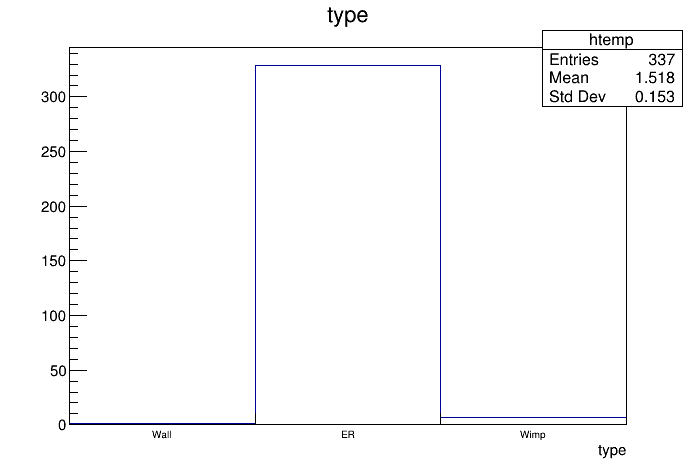

In [17]:
// Show here the number of events for each generated model.

TCanvas *c2 = new TCanvas();
tree->Draw("type");
c2->Draw();

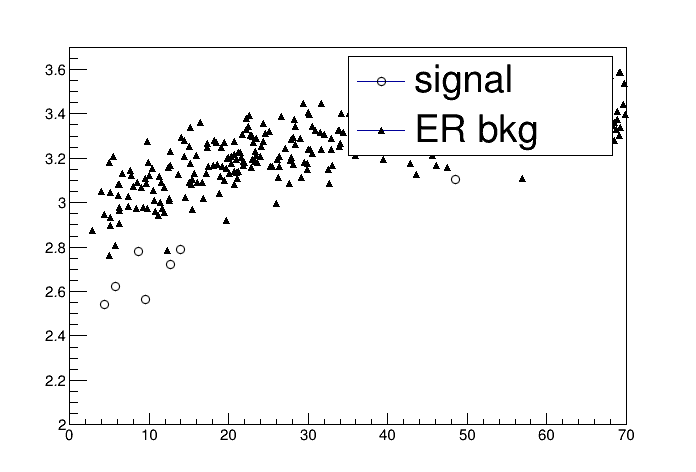

In [18]:
// A bit more fancy plotting ;)

TCanvas *c4 = new TCanvas();
gStyle->SetOptTitle(kFALSE);
gStyle->SetOptStat(0);

TH2F *h = new TH2F("h","signal",100,0,70,100,2,3.7);
h->SetMarkerStyle(kOpenCircle);
tree->Draw("cs2:cs1>>h","type==\"Wimp\"");  // this is actually log10(cs2)
TH2F *h2 = new TH2F("h2","ER bkg",100,0,70,100,2,3.7);
h2->SetMarkerStyle(kFullTriangleUp);
tree->Draw("cs2:cs1>>h2","type==\"ER\"");
h->Draw("P");
h2->Draw("SAME P");
gPad->BuildLegend();
c4->Draw();

# That's it!

### **A real life example** of how to play with this class and actually generate toys is in the SR1 [repository](https://github.com/XENON1T/SR1Results/tree/master/StatisticalAnalyses/xephyr_sr1_likelihood) and the file dedicated to toy generation is  [toy_gen_main.cxx](https://github.com/XENON1T/SR1Results/blob/master/StatisticalAnalyses/xephyr_sr1_likelihood/toy_gen_main.cxx)
### **The next Tutorial:** computing the distribution of the test statistic from fit of the generated toy data. You find it [here](https://github.com/XENON1T/Xephyr/blob/master/notebooks/ToyFitter.ipynb)

### Appendix: How to generate null hypothesis:

using the already initialized toy generator above, you can do this simply specifying mu = 0

In [19]:
treeName = "test_mu0_V0_Gen1";      // remember to change the tree name ;)
mu = 0;                             // and mu
toy.setTreeName(treeName);
toy.generateData( mu, N, false );   // generate fake dark matter data, this will create a file in $XEPHYR_DIR 
toy.generateCalibration( N, false); 

 Id Name                 Type         Current Value               Uncertainty
 -1 Sigma                Of interest        0                 
  1 CNNSscale0           Nuisance        -1.4                 
  2 RadioscaleNX0        Nuisance       -0.94                 
  3 Radioscale0          Nuisance        0.36                 
  4 ACscale0             Nuisance        0.78                 
  5 Wallscale0           Nuisance         1.3                 
  6 ERscale0             Free             0.2                 
  7 _py0_                Free            0.12                 
  8 _rf0_                Free             1.7                 
  9 SignalScale0         Nuisance         1.9                 
